In [1]:
from edge_sim_py import *
import math
import os
import random
import msgpack
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def custom_collect_method(self) -> dict: # Custom collect method to measure the power consumption of each server
    metrics = {
        "Instance ID": self.id,
        "Power Consumption": self.get_power_consumption(),
    }
    return metrics

power_list = list() # List to store total power consumption everytime the task scheduling algorithm is used

In [3]:
def my_algorithm(parameters):
    
    print("\n\n")
    total_power = 0 #We sum the power consumption after migrating each service
    for service in Service.all(): #Iterate over every service
        
 
        if not service.being_provisioned: #If service needs to be migrated

            
            #To sort edge servers based on their available free resources, we will use Python's "sorted" method. 
            #The server capacity is represented by three layers: CPU, memory, and disk. To determine the average resource utilization of each server, 
            #we calculate the geometric mean of these three layers. Finally, we set the "reverse" attribute of the sorted method to "True," 
            #allowing us to arrange the edge servers in descending order of their free resources.


            edge_servers = sorted(
                EdgeServer.all(),
                key=lambda s: ((s.cpu - s.cpu_demand) * (s.memory - s.memory_demand) * (s.disk - s.disk_demand)) ** (1 / 3),
                reverse=True,
            )

            for edge_server in edge_servers:
                # Check if the edge server has resources to host the service
                if edge_server.has_capacity_to_host(service=service):
                    # We just need to migrate the service if it's not already in the least occupied edge server
                    if service.server != edge_server:
                        print(f"[STEP {parameters['current_step']}] Migrating {service} From {service.server} to {edge_server}")
                        
                        service.provision(target_server=edge_server)

                        
                        #get the sum of powerconsumption of each edge server
                        power = 0

                        for iter_edge_server in EdgeServer.all():
                            power = power + iter_edge_server.get_power_consumption()
                        
                        #Add power consumption after migrating current service
                        total_power += power
                        
                        # After start migrating the service we can move on to the next service
                        break

    #Append to power_list for plotting
    power_list.append(total_power)

In [4]:
def stopping_criterion(model: object):    
    # As EdgeSimPy will halt the simulation whenever this function returns True,
    # its output will be a boolean expression that checks if the current time step is 600
    return model.schedule.steps == 1000

In [5]:
simulator = Simulator(
    tick_duration=1,
    tick_unit="seconds",
    stopping_criterion=stopping_criterion,
    resource_management_algorithm=my_algorithm,
)

In [6]:
# Loading a sample dataset 
#simulator.initialize(input_file="datasets/sample_dataset.json")
simulator.initialize(input_file="https://raw.githubusercontent.com/EdgeSimPy/edgesimpy-tutorials/master/datasets/sample_dataset1.json")

In [7]:
#Assigning the custom collect method
EdgeServer.collect = custom_collect_method

# Executing the simulation
simulator.run_model()




[STEP 1] Migrating Service_1 From EdgeServer_5 to EdgeServer_1
[STEP 1] Migrating Service_2 From EdgeServer_5 to EdgeServer_2
[STEP 1] Migrating Service_3 From EdgeServer_6 to EdgeServer_5
[STEP 1] Migrating Service_4 From EdgeServer_4 to EdgeServer_6
[STEP 1] Migrating Service_5 From EdgeServer_4 to EdgeServer_1
[STEP 1] Migrating Service_6 From EdgeServer_6 to EdgeServer_2



[STEP 2] Migrating Service_3 From EdgeServer_5 to EdgeServer_6
[STEP 2] Migrating Service_4 From EdgeServer_6 to EdgeServer_1



[STEP 3] Migrating Service_1 From EdgeServer_1 to EdgeServer_5
[STEP 3] Migrating Service_2 From EdgeServer_2 to EdgeServer_5
[STEP 3] Migrating Service_3 From EdgeServer_6 to EdgeServer_5



[STEP 4] Migrating Service_1 From EdgeServer_5 to EdgeServer_6
[STEP 4] Migrating Service_2 From EdgeServer_5 to EdgeServer_2
[STEP 4] Migrating Service_3 From EdgeServer_5 to EdgeServer_6



[STEP 5] Migrating Service_2 From EdgeServer_2 to EdgeServer_5
[STEP 5] Migrating Service_3 From EdgeSe

In [8]:
#Retrieving logs dataframe for plot
logs = pd.DataFrame(simulator.agent_metrics["EdgeServer"])
#print(logs)

df = logs

edge_server_ids = df['Instance ID'].unique()

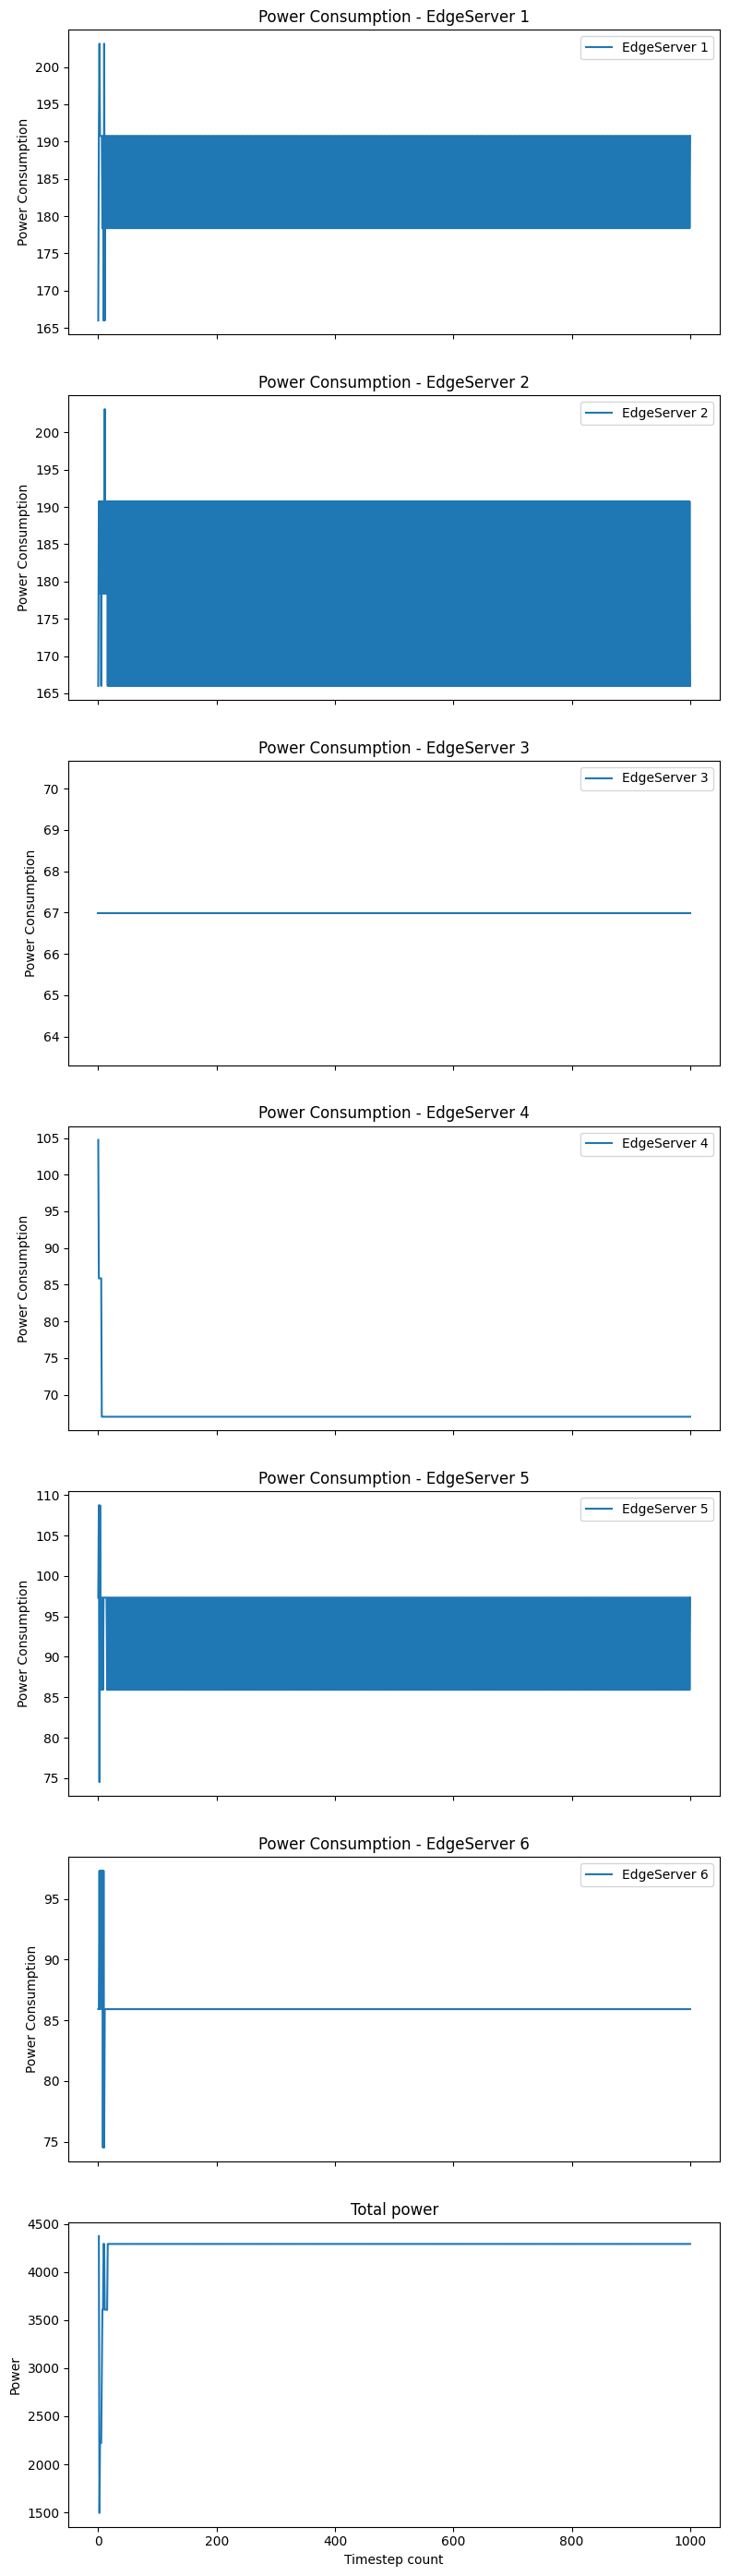

In [9]:
# Determine the number of subplots based on the number of EdgeServers
num_subplots = len(edge_server_ids) + 1  # Add 1 for the rewards subplot

# Create subplots with the desired layout
fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 4*num_subplots), sharex=True)

# Iterate over each EdgeServer and plot the data in the corresponding subplot
for i, edge_server_id in enumerate(edge_server_ids):
    # Filter the data for the current EdgeServer
    edge_server_data = df[df['Instance ID'] == edge_server_id]

    # Extract the timestep and power consumption values
    timesteps = edge_server_data['Time Step']
    power_consumption = edge_server_data['Power Consumption']

    # Plot the power consumption data for the current EdgeServer in the corresponding subplot
    axes[i].plot(timesteps, power_consumption, label=f"EdgeServer {edge_server_id}")

    # Set the subplot title and labels
    axes[i].set_title(f"Power Consumption - EdgeServer {edge_server_id}")
    axes[i].set_ylabel("Power Consumption")
    axes[i].legend()

# Create a separate subplot for total power
power_subplot = axes[-1]
power_count_list = list(range(1, len(power_list) + 1))
power_subplot.plot(power_count_list, power_list)
power_subplot.set_title("Total power")
power_subplot.set_xlabel("Timestep count")
power_subplot.set_ylabel("Power")

# Adjust the spacing between subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

# Save the plot
#plt.show()

plt.savefig('Worst_fit_migration_power_consumption_final_uncropped.png')